In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

with open('data_with_ratios.pickle', 'rb') as fp:
    data = pickle.load(fp)
data[0]

{'bankrupt': False,
 'company': '1 800 FLOWERS COM INC',
 'debt_equity': [{'date': '10/11/11', 'value': 1.0021245910865666},
  {'date': '11/5/12', 'value': 0.663752116916515},
  {'date': '8/2/13', 'value': 0.6734745379744236},
  {'date': '7/2/14', 'value': 0.5599597519134336},
  {'date': '6/2/15', 'value': 1.625391648658562},
  {'date': '5/2/16', 'value': 1.4601248373706712},
  {'date': '10/2/17', 'value': 1.1585393070356524},
  {'date': '9/2/18', 'value': 0.9615379963838884}],
 'equity': [{'date': '10/11/11', 'value': 142145000.0},
  {'date': '11/5/12', 'value': 159430000.0},
  {'date': '8/2/13', 'value': 170391000.0},
  {'date': '7/2/14', 'value': 181872000.0},
  {'date': '6/2/15', 'value': 226287000.0},
  {'date': '5/2/16', 'value': 258255999.99999997},
  {'date': '10/2/17', 'value': 286768000.0},
  {'date': '9/2/18', 'value': 330742000.0}],
 'roe': [{'date': '10/11/11', 'value': 0.07109641563192515},
  {'date': '11/5/12', 'value': 0.09914068870350624},
  {'date': '8/2/13', 'value':

In [3]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

new_data = []
bankrupt = []
cols = data[0].keys()
MIN_ROWS = 5
ZSCORE = 1.8
for obj in data:
    if (len(obj.keys()) <= 28):
        continue
    cols = intersection(cols, obj.keys())
cols = sorted(cols)
print(cols)

ground_truth = []
ground_bankrupt = []

for obj in data:
    if not obj['bankrupt']:
        continue
    valid = True
    new_obj = []
    for i in range(MIN_ROWS):
        new_vals = []
        for key in cols:
            if key not in obj:
                valid = False
                break
            if (isinstance(obj[key], list) and key not in ['equity', 'roe', 'bad_solvency', 'debt_equity']):
                if len(obj[key]) < MIN_ROWS:
                    valid = False
                    break
                new_vals.append(obj[key][i]['value'])
        new_obj.append(new_vals)
    if (valid):
        ground_bankrupt.append(True)
        ground_truth.append(new_obj)

for obj in data:
    if obj['bankrupt']:
        continue
    valid = True
    new_obj = []
    for i in range(MIN_ROWS):
        new_vals = []
        for key in cols:
            if key not in obj:
                valid = False
                break
            if (isinstance(obj[key], list) and key not in ['equity', 'roe', 'bad_solvency', 'debt_equity']):
                if len(obj[key]) < MIN_ROWS:
                    valid = False
                    break
                new_vals.append(obj[key][i]['value'])
        new_obj.append(new_vals)
    if (valid):
#         ban = obj['bankrupt']
#         if 'zscore' in obj:
#             for zscore in obj['zscore']:
#                 if zscore['value'] < ZSCORE:
#                     ban = True
        neg_equity = False
        neg_roe = False
        bad_solvency = False
        bad_debt = False
        if 'equity' in obj:
            for equity in obj['equity']:
                if equity['value'] < 0:
                    neg_equity = True
        if 'roe' in obj:
            current_roe = None
            for roe in obj['roe']:
                if current_roe and roe['value'] < current_roe / 2:
                    neg_roe = True
                current_roe = roe['value']
        if 'bad_solvency' in obj:
            for solv in obj['bad_solvency']:
                if solv['value'] < 2:
                    bad_solvency = True
        if 'debt_equity' in obj:
            for de in obj['debt_equity']:
                if de['value'] > 2:
                    bad_debt = True
        bankrupt.append((neg_equity or neg_roe) and (bad_debt or bad_solvency))
        new_data.append(new_obj)

['bankrupt', 'company', 'debt_equity', 'equity', 'solvency', 'ticker', 'x10', 'x15', 'x16', 'x17', 'x2', 'x29', 'x3', 'x41', 'x50', 'x55', 'x7', 'x8']


In [4]:
true_bankrupt = []
zscore_bankrupt = []
for obj in data:
    if obj['bankrupt']:
        true_bankrupt.append(obj['ticker'])
    if ('zscore' in obj):
        for zscore in obj['zscore']:
            if zscore['value'] < 1.8:
                zscore_bankrupt.append(obj['ticker'])
                break
intersect = set(true_bankrupt) & set(zscore_bankrupt)
print('True Bankrupt')
print(len(true_bankrupt))
print(true_bankrupt)
print('Bankrupt by Z score')
print(len(zscore_bankrupt))
print(zscore_bankrupt)
print('Intersect')
print(len(intersect))
print(intersect)

True Bankrupt
44
['NCSO', 'ARO', 'ACI', 'ASNA', 'BONT', 'BKU', 'CPN', 'CIT', 'CMLS', 'CHTR', 'CIE', 'DAL', 'DNKN', 'DYN', 'DEST', 'DDMG', 'EFH', 'FRP', 'CK00007861', 'GGP', 'GGP', 'GM', 'ACF', 'GMAN', 'HCOM', 'ZINCQ', 'LEA', 'LEE', 'LNGG', 'LYB', 'MFRM', 'ODP', 'PIR', 'RFP', 'SHLD', 'SHO', 'SMRT', 'SIX', 'C730', 'CK00015847', '', 'TRCO', 'TSQ', 'TROX']
Bankrupt by Z score
747
['FOX', 'ABT', 'AKR', 'ACCO', 'ARAY', 'ACW', 'ACRX', 'ACET', 'ADOM', 'ADT', 'ADRO', 'AMD', 'AEHR', 'ACY', 'AJRD', 'AES', 'AMG', 'SO', 'AIRI', 'AL', 'AKS', 'ALK', 'ALB', 'ALR', 'ALX', 'ALCO', 'ADS', 'LNT', 'AMOT', 'MDRX', 'ALNY', 'ANAV', 'ALPN', 'AEE', 'ABMC', 'AEP', 'AMSC', 'AMT', 'APU', 'AMP', 'FOLD', 'AMKR', 'AHS', 'APC', 'AVXL', 'AR', 'APA', 'AIV', 'ARCI', 'ARCW', 'ACI', 'PNW', 'AWI', 'ARTX', 'ARQL', 'ARRY', 'ASH', 'ASPN', 'ATRO', 'ASTC', 'T', 'AAWW', 'ATW', 'ADP', 'AVB', 'AVNW', 'AVA', 'ACLS', 'ACHC', 'ACAD', 'ACLZ', 'ADTM', 'ADPT', 'ASNB', 'AGHI', 'AA', 'ALEX', 'ARE', 'Y', 'ATI', 'AGN', 'ALE', 'ALSN', 'ALT', 

In [5]:
not_detected = [b for b in true_bankrupt if b not in zscore_bankrupt]
print(not_detected)
for obj in data:
    if obj['ticker'] in not_detected:
        if 'zscore' in obj:
            print(obj['ticker'])
            print(obj['zscore'])
#         else:
#             print(obj['ticker'])

['NCSO', 'ARO', 'ASNA', 'BONT', 'BKU', 'CIT', 'DEST', 'DDMG', 'CK00007861', 'ACF', 'GMAN', 'ZINCQ', 'LEA', 'LNGG', 'LYB', 'MFRM', 'ODP', 'PIR', 'SMRT', 'CK00015847', '', 'TRCO', 'TROX']
ARO
[{'value': 9.42717009992146, 'date': '8/12/10'}, {'value': 9.872457180713567, 'date': '3/6/11'}]
ASNA
[{'value': 5.83933649983558, 'date': '9/6/11'}, {'value': 6.97692340830925, 'date': '1/3/12'}, {'value': 4.284513750136817, 'date': '4/3/13'}, {'value': 4.790147416052633, 'date': '3/3/14'}, {'value': 4.277927708003096, 'date': '3/3/15'}, {'value': 2.2732138946707994, 'date': '1/3/16'}, {'value': 2.9813499518295137, 'date': '8/6/17'}, {'value': 3.031318404692856, 'date': '5/3/18'}]
BONT
[{'value': 2.0314942241645726, 'date': '7/12/11'}, {'value': 2.2940571223782764, 'date': '11/4/12'}, {'value': 2.2748608137511175, 'date': '17/4/13'}, {'value': 2.2829921108696043, 'date': '16/4/14'}, {'value': 2.2215037249441414, 'date': '15/4/15'}, {'value': 2.154344385539776, 'date': '13/4/16'}, {'value': 2.089716

In [6]:
arr = np.array(new_data)
test_arr = np.array(ground_truth)
arr.shape

(1362, 5, 13)

In [7]:
def train_model(x_train, y_train, units, dropout, num_lstm_layers, model_type, epoch, batch_size):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'lstm' 
            else GRU(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'gru' 
            else SimpleRNN(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True) if model_type == 'lstm' else 
            GRU(units, return_sequences=True) if model_type == 'gru' else
            SimpleRNN(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units) if model_type == 'lstm' else 
            GRU(units) if model_type == 'gru' else
            SimpleRNN(units),
            Dropout(dropout),
            Dense(1, activation = 'sigmoid')
        ])
    model.compile(optimizer=optimizers.RMSprop(lr=0.003),loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size)
    return model, history

In [8]:
scalers = {}
for i in range(arr.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(0,1))
    arr[:, :, i] = scalers[i].fit_transform(arr[:, :, i])
    test_arr[:, :, i] = scalers[i].transform(test_arr[:, :, i])
x_train, x_test, y_train, y_test = train_test_split(arr, bankrupt, test_size=0.15, random_state=42)
print('bankrupt:')
print(len([True for b in bankrupt if b]))
print('not bankrupt:')
print(len([True for b in bankrupt if not b]))

bankrupt:
445
not bankrupt:
917


In [9]:
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm', EPOCH, BATCH_SIZE)

Epoch 1/100
1157/1157 [==============================] - 6s 5ms/step - loss: 0.6591 - acc: 0.6698
Epoch 2/100
1157/1157 [==============================] - 1s 635us/step - loss: 0.6342 - acc: 0.6742
Epoch 3/100
1157/1157 [==============================] - 1s 706us/step - loss: 0.6364 - acc: 0.6742
Epoch 4/100
1157/1157 [==============================] - 3s 2ms/step - loss: 0.6283 - acc: 0.6742
Epoch 5/100
1157/1157 [==============================] - 1s 584us/step - loss: 0.6158 - acc: 0.6750 0s - loss: 0.6153 - ac
Epoch 6/100
1157/1157 [==============================] - 1s 615us/step - loss: 0.6108 - acc: 0.6768
Epoch 7/100
1157/1157 [==============================] - 1s 656us/step - loss: 0.6084 - acc: 0.6768
Epoch 8/100
1157/1157 [==============================] - 3s 2ms/step - loss: 0.5960 - acc: 0.6759
Epoch 9/100
1157/1157 [==============================] - 1s 623us/step - loss: 0.5997 - acc: 0.6733
Epoch 10/100
1157/1157 [==============================] - 1s 606us/step - loss: 0.5

1157/1157 [==============================] - 1s 698us/step - loss: 0.5073 - acc: 0.7295
Epoch 82/100
1157/1157 [==============================] - 3s 2ms/step - loss: 0.5100 - acc: 0.7381
Epoch 83/100
1157/1157 [==============================] - 1s 835us/step - loss: 0.4933 - acc: 0.7494
Epoch 84/100
1157/1157 [==============================] - 1s 706us/step - loss: 0.5113 - acc: 0.7416
Epoch 85/100
1157/1157 [==============================] - 1s 777us/step - loss: 0.4979 - acc: 0.7537
Epoch 86/100
1157/1157 [==============================] - 1s 1ms/step - loss: 0.5054 - acc: 0.7407
Epoch 87/100
1157/1157 [==============================] - 3s 2ms/step - loss: 0.4855 - acc: 0.7494
Epoch 88/100
1157/1157 [==============================] - 1s 763us/step - loss: 0.5140 - acc: 0.7234
Epoch 89/100
1157/1157 [==============================] - 1s 776us/step - loss: 0.4899 - acc: 0.7494
Epoch 90/100
1157/1157 [==============================] - 1s 756us/step - loss: 0.5060 - acc: 0.7243
Epoch 91/

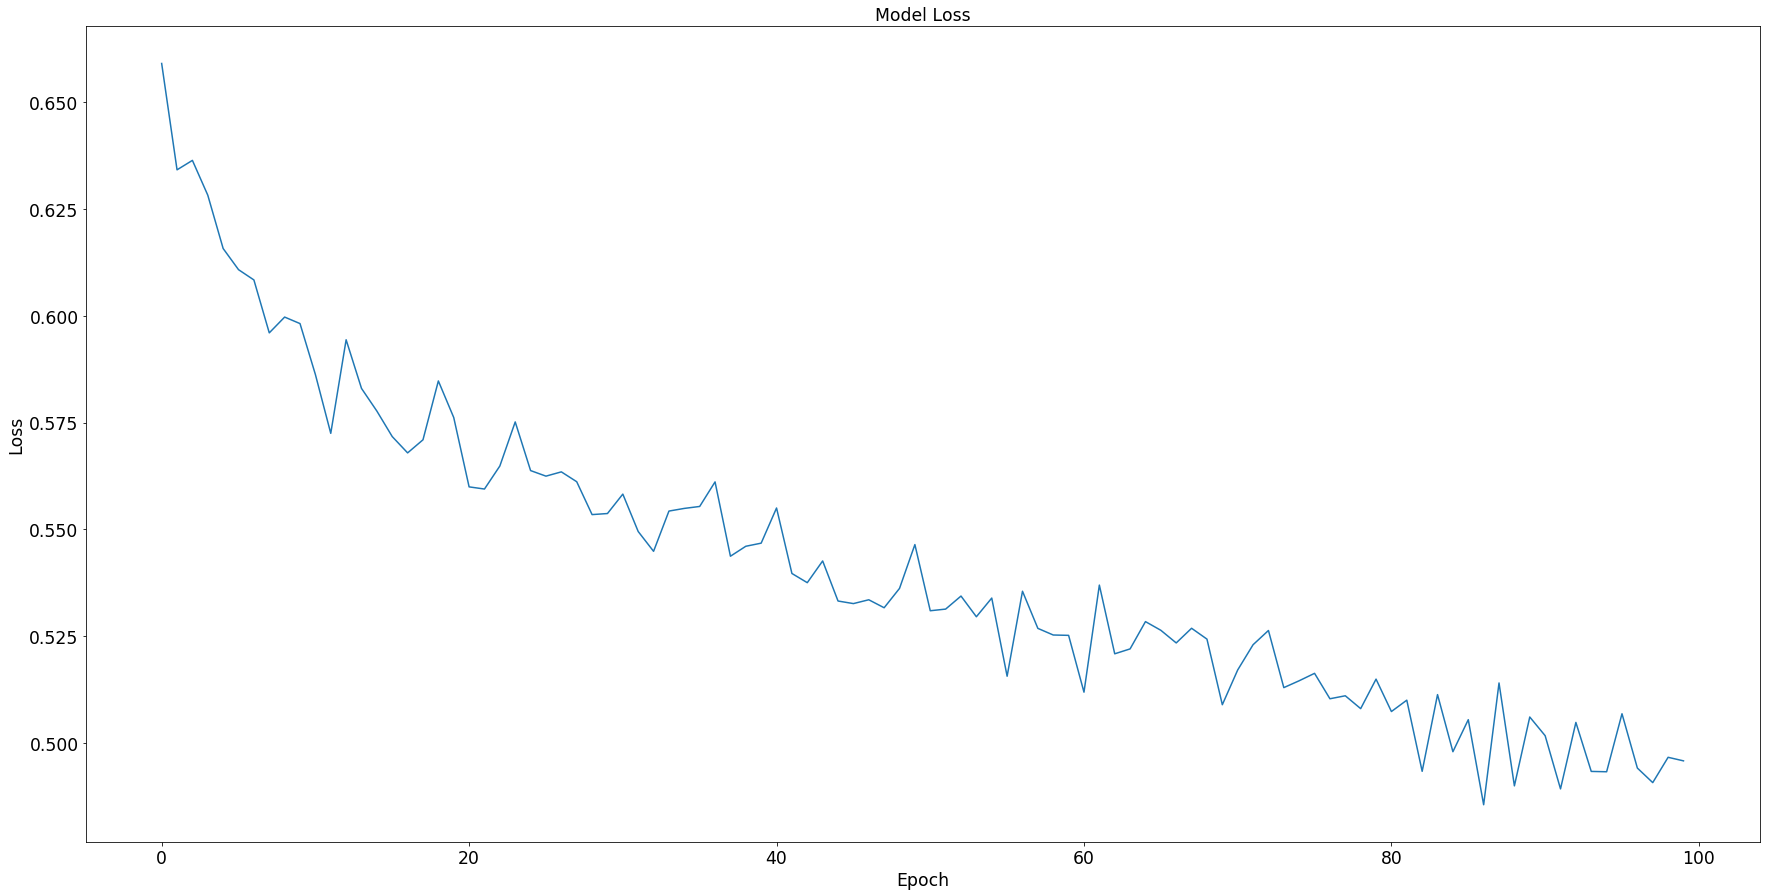

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
plot_loss(lstm_history)

In [11]:
# Evaluate model and predict data
scores = lstm_model.evaluate(x_test, y_test)
print("model: \n%s: %.2f%%" % (lstm_model.metrics_names[1], scores[1]*100))

y_predict = lstm_model.predict_classes(x_test)
cm = confusion_matrix(y_test, y_predict)
print(cm)

fpr_BDmodel, tpr_BDmodel, thresholds_BDmodel = roc_curve(y_test, y_predict)
auc_BDmodel = auc(fpr_BDmodel, tpr_BDmodel)
print(auc_BDmodel)

205/205 [==============================] - 1s 4ms/step
model: 
acc: 60.00%
[[69 68]
 [14 54]]
0.6488836410476598


In [12]:
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

(69, 68, 14, 54)

In [13]:
# Evaluate model and predict data
scores = lstm_model.evaluate(test_arr, ground_bankrupt)
print("model: \n%s: %.2f%%" % (lstm_model.metrics_names[1], scores[1]*100))

y_predict = lstm_model.predict_classes(test_arr)
cm = confusion_matrix(ground_bankrupt, y_predict)
print(cm)

# fpr_BDmodel, tpr_BDmodel, thresholds_BDmodel = roc_curve(ground_bankrupt, y_predict)
# auc_BDmodel = auc(fpr_BDmodel, tpr_BDmodel)
# print(auc_BDmodel)

24/24 [==============================] - 0s 281us/step
model: 
acc: 87.50%
[[ 0  0]
 [ 3 21]]
